# SpamOrNonSpamAnalysis

Spam filtering is an example of document classification task which involves classifying an email / SMS as spam or non-spam (a.k.a. ham).

1. Import the dataset from https://www.kaggle.com/uciml/sms-spam-collection-dataset. (1 point).
2. Split the data into training and testing. (1 point). Use 10-fold cross validation.(1 point)
3. Extract features using TF-IDF and display the features. ( 2 points)
4. Model and train the classifier using GaussianNB, BernoulliNB and MultinomialNB.( 3 points)
5. Evaluate classifiers on Test Data. ( 2 points)
6. Plot the decision boundary, visualize training and test results of all the models (3 points)

## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk
from itertools import product
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

## Importing data

In [2]:
data = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Understanding statistics of data

In [4]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


## Drop the columns which are not significant

In [5]:
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],  axis=1)

## Understanding statistics of data

In [6]:
data.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Convert the categorical class Attribute to numerical Value

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['v1'])
data['v1'] = le.transform(data.v1.values)

In [8]:
data.describe()

,v1
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pallssin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pallssin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Purpose : Function to keep only alphabets, digits and certain words (punctuations, question marks, tabs etc. removed) 
### Input : Takes a text corpus, 'corpus' to be cleaned along with a list of words, 'keep_list', which have to be retained even after the cleaning process
### Output : Returns the cleaned text corpus

In [10]:
def text_clean(corpus, keep_list):
    cleaned_corpus = pd.Series()
    for row in corpus:
        qs = []
        for word in row.split():
            if word not in keep_list:
                p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
                p1 = p1.lower()
                qs.append(p1)
            else : qs.append(word)
        cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
    return cleaned_corpus

### Purpose : Function to perform all pre-processing tasks (cleaning, stemming, lemmatization, stopwords removal          etc.)
### Input : 
### 'corpus' - Text corpus on which pre-processing tasks will be performed
### 'keep_list' - List of words to be retained during cleaning process
### 'cleaning', 'stemming', 'lemmatization', 'remove_stopwords' - Boolean variables indicating whether a particular task should be performed or not
### 'stem_type' - Choose between Porter stemmer or Snowball(Porter2) stemmer. Default is "None", which corresponds to Porter Stemmer. 'snowball' corresponds to Snowball Stemmer 
### Note : Either stemming or lemmatization should be used. There's no benefit of using both of them together
### Output : Returns the processed text corpus

In [11]:
def preprocess(corpus, keep_list, cleaning = True, stemming = True, stem_type = None, lemmatization = True, remove_stopwords = True):

    if cleaning == True:
        corpus = text_clean(corpus, keep_list)
    
    if remove_stopwords == True:
        wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
        stop = set(stopwords.words('english'))
        for word in wh_words:
            stop.remove(word)
        corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    else :
        corpus = [[x for x in x.split()] for x in corpus]
    
    if lemmatization == True:
        lem = WordNetLemmatizer()
        corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    
    if stemming == True:
        if stem_type == 'snowball':
            stemmer = SnowballStemmer(language = 'english')
            corpus = [[stemmer.stem(x) for x in x] for x in corpus]
        else :
            stemmer = PorterStemmer()
            corpus = [[stemmer.stem(x) for x in x] for x in corpus]
    
    corpus = [' '.join(x) for x in corpus]
        

    return corpus

In [12]:
data.describe()

,v1
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Preforming cleaning, stemming, lemmatization and removing stop words

In [13]:
common_dot_words = ['U.S.', 'St.', 'Mr.', 'Mrs.', 'D.C.']
preprocessed_data = preprocess(data['v2'], keep_list = common_dot_words, remove_stopwords = True)

In [14]:
preprocessed_data[:10]

['go jurong point crazi avail bugi n great world la e buffet cine get amor wat',
 'ok lar joke wif u oni',
 'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18',
 'u dun say earli hor u c alreadi say',
 'nah think go usf live around though',
 'freemsg hey darl 3 week word back like fun still tb ok xxx std chg send 1 50 rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press 9 copi friend callertun',
 'winner valu network custom select receivea 900 prize reward claim call 09061701461 claim code kl341 valid 12 hour',
 'mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030']

In [15]:
Y = data['v1']

In [16]:
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: v1, dtype: int64

In [17]:
X = pd.DataFrame(preprocessed_data)
X = X[0]

In [18]:
X.describe()

count                 5572
unique                5112
top       sorri call later
freq                    30
Name: 0, dtype: object

## Splitting the dataset into the Training set and Test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)

In [20]:
X_train

1257                                         also cbe pay
5461                          ok thk get u wan 2 come wat
1612    rt king pro video club need help info ringtone...
2179                             pop lt gt ibuprofen help
2638                                      gobi art colleg
                              ...                        
3297    messag free welcom new improv sex dog club uns...
1054    hiya comin 2 bristol 1 st week april le get ru...
245                          late say websit dont slipper
1235    opinion 1 2 jada 3 kusruthi 4 lovabl 5 silent ...
3361                                    messag phone hold
Name: 0, Length: 4457, dtype: object

## Fitting the training data on TfidfVectorizer

In [21]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
print(X_train.shape)

(4457, 6296)


## Tranforming the test data on the built TfidfVectorizer

In [22]:
X_test = vectorizer.transform(X_test)
print(X_test.shape)

(1115, 6296)


## 10-fold cross validation and GridSearchCV to Estimate Best Parameters
## Fitting  GaussianNB to the Training set and Predicting on Test Data

In [23]:
clf = GaussianNB()

In [24]:
parameters = {
    'var_smoothing': [1e-9, 0.7e-9, 0.4e-9, 0.2e-9, 0.1e-9, 0.09e-9, 0.08e-9, 0.07e-9, 0.06e-9, 0.03e-9, 0.01e-9] 
}

grid = GridSearchCV(clf, param_grid = parameters, cv=10, refit=True)
grid.fit(X_train.toarray(), y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': [1e-09, 7e-10, 4e-10, 2e-10, 1e-10,
                                           9e-11, 8e-11, 7e-11, 6e-11, 3e-11,
                                           1e-11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
print(grid.best_score_)
print(grid.best_params_)

0.8682853831813373
{'var_smoothing': 1e-09}


In [26]:
grid.score(X_test.toarray(), y_test)

0.8672645739910314

## Fitting  MultinomialNB to the Training set and Predicting on Test Data

In [27]:
clf = MultinomialNB()

In [28]:
parameters = {
    'alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01] 
}

grid = GridSearchCV(clf, param_grid = parameters, cv=10, refit=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07,
                                   0.06, 0.03, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
print(grid.best_score_)
print(grid.best_params_)

0.9858648662266336
{'alpha': 0.08}


In [30]:
grid.score(X_test.toarray(), y_test)

0.9757847533632287

## Fitting  BernoulliNB to the Training set and Predicting on Test Data

In [31]:
clf = BernoulliNB()

In [32]:
parameters = {
    'alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01] 
}

grid = GridSearchCV(clf, param_grid = parameters, cv=10, refit=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07,
                                   0.06, 0.03, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
print(grid.best_score_)
print(grid.best_params_)

0.9896795485463799
{'alpha': 0.1}


In [34]:
grid.score(X_test.toarray(), y_test)

0.9820627802690582

## Plotting decision regions

(-1.0, 1.7000000000000024)

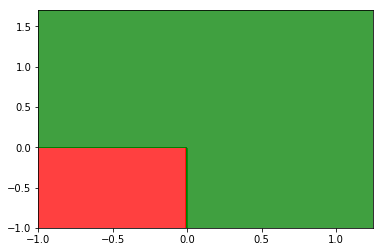

In [35]:
from matplotlib.colors import ListedColormap

X_set, y_set = X_train[:, :2], y_train
clf.fit(X_set, y_set)

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())